<a href="https://colab.research.google.com/github/The-Mechanic-3/Data-Driven-Aerospace/blob/Colab/DataDrivenFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Code Verion

Added 1000 synthetic samples to the dataset.
Epoch [10/500], Train Loss: 0.7912, Validation Loss: 0.6746
Epoch [20/500], Train Loss: 0.6852, Validation Loss: 0.5619
Epoch [30/500], Train Loss: 0.5904, Validation Loss: 0.5041
Epoch [40/500], Train Loss: 0.5145, Validation Loss: 0.4357
Epoch [50/500], Train Loss: 0.4873, Validation Loss: 0.4079
Epoch [60/500], Train Loss: 0.4627, Validation Loss: 0.3853
Epoch [70/500], Train Loss: 0.4451, Validation Loss: 0.3692
Epoch [80/500], Train Loss: 0.4145, Validation Loss: 0.3568
Epoch [90/500], Train Loss: 0.4087, Validation Loss: 0.3468
Epoch [100/500], Train Loss: 0.4040, Validation Loss: 0.3428
Epoch [110/500], Train Loss: 0.3831, Validation Loss: 0.3378
Epoch [120/500], Train Loss: 0.3807, Validation Loss: 0.3338
Epoch [130/500], Train Loss: 0.3729, Validation Loss: 0.3328
Epoch [140/500], Train Loss: 0.3630, Validation Loss: 0.3278
Epoch [150/500], Train Loss: 0.3448, Validation Loss: 0.3258
Epoch [160/500], Train Loss: 0.3544, Validation L

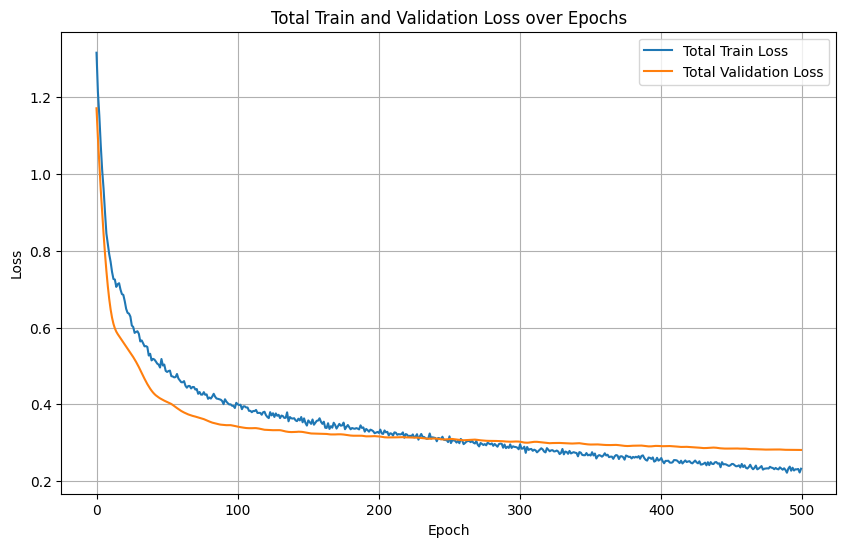

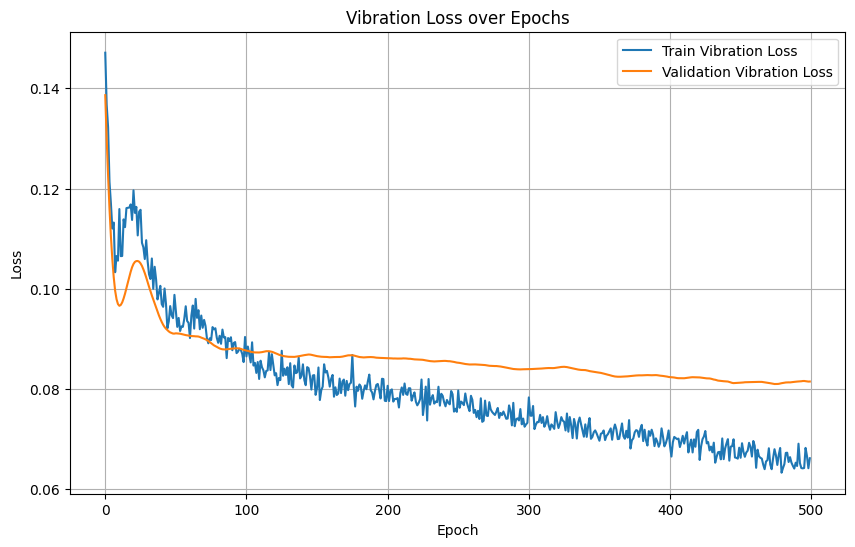

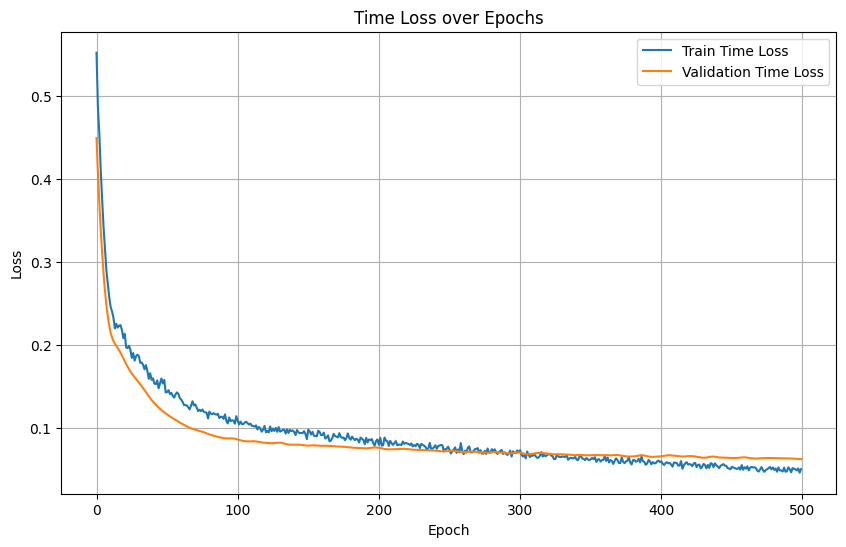

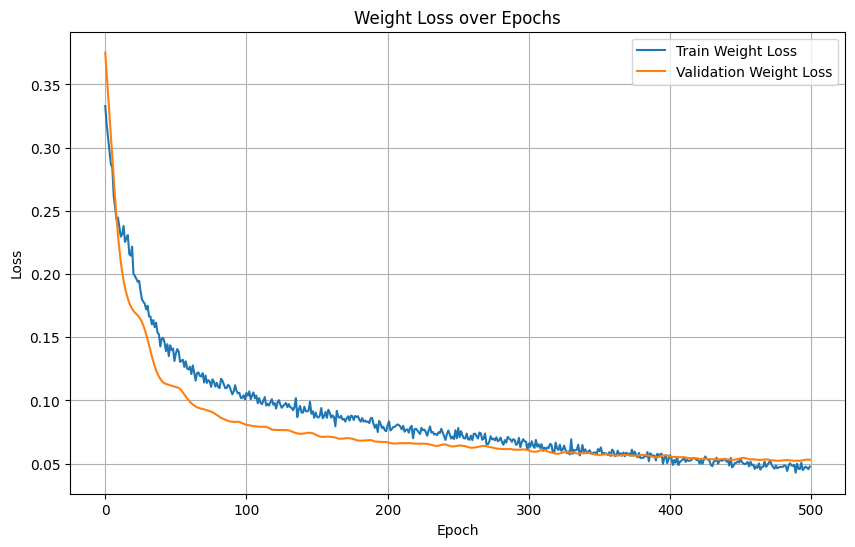

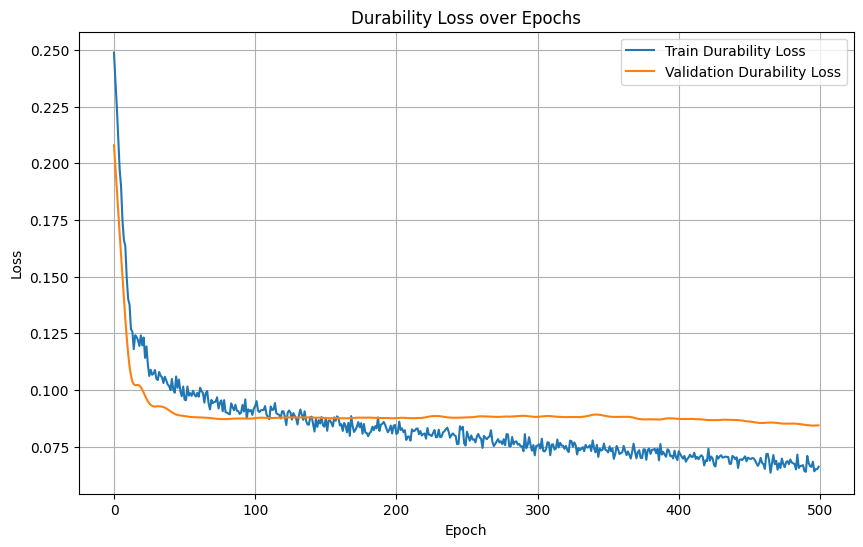

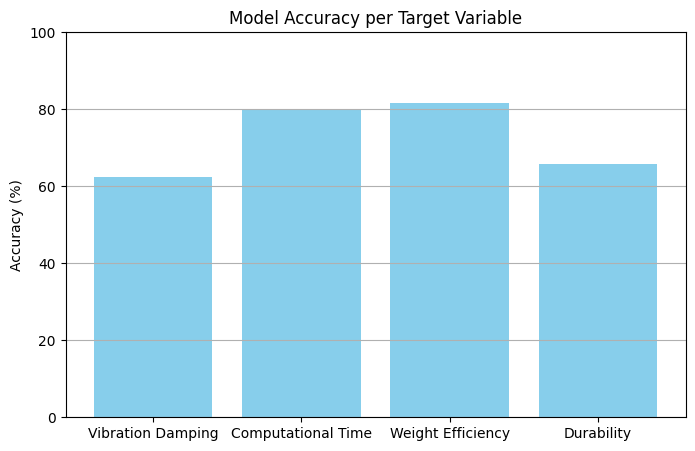


Evaluation complete.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


# Load the dataset
dataset = pd.read_csv('/content/sample_data/aerospace_structural_design_dataset.csv')

# Synthetic Data Generation and Merging
import random

# Define feature and target columns
numerical_features = ['E (GPa)', 'ν', 'ρ (kg/m³)', 'Tensile Strength (MPa)', 'Young’s Modulus',
                      'Altitude (m)', 'Temperature (°C)', 'Pressure (Pa)', 'Operational Life (years)',
                      'Wing Span (m)', 'Fuselage Length (m)', 'Structural Thickness (mm)', 'Number of Iterations',
                      'Optimization Time (sec)']
categorical_features = ['Material Type', 'Structural Shape', 'Load Distribution', 'Quantum Algorithm Type']

# Target variables
target_columns = ['Vibration Damping', 'Computational Time', 'Weight Efficiency', 'Durability']

# Create synthetic samples by randomly perturbing real samples
num_synthetic = 1000  # Number of synthetic samples to generate
synthetic_data = []
synthetic_targets = {key: [] for key in target_columns}

# Pull from existing numeric ranges
X_real_only = dataset[numerical_features]





for _ in range(num_synthetic):
    base = X_real_only.sample(n=1, random_state=random.randint(1, 10000)).iloc[0].copy()
    synthetic_sample = base + np.random.normal(0, 0.05, size=len(base))  # slight perturbation
    synthetic_data.append(synthetic_sample.values)

    # Simple heuristic: make targets proportional to certain inputs (no physics enforcement here)
    synthetic_targets['Vibration Damping'].append(
        'High' if synthetic_sample['Young’s Modulus'] > X_real_only['Young’s Modulus'].median() else 'Low')
    synthetic_targets['Computational Time'].append(
        'Long' if synthetic_sample['Number of Iterations'] > X_real_only['Number of Iterations'].median() else 'Short')
    synthetic_targets['Weight Efficiency'].append(
        'Excellent' if synthetic_sample['ρ (kg/m³)'] < X_real_only['ρ (kg/m³)'].median() else 'Poor')
    synthetic_targets['Durability'].append(
        'High' if synthetic_sample['Tensile Strength (MPa)'] > X_real_only['Tensile Strength (MPa)'].median() else 'Low')

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=numerical_features)
synthetic_targets_df = pd.DataFrame(synthetic_targets)
synthetic_df[target_columns] = synthetic_targets_df

# Match original dataset's column types for safe concatenation
for col in target_columns:
    synthetic_df[col] = synthetic_df[col].astype(dataset[col].dtype)

# Combine with original dataset
dataset = pd.concat([dataset, synthetic_df], ignore_index=True)

print(f"Added {num_synthetic} synthetic samples to the dataset.")




# Split features and targets
X = dataset[numerical_features + categorical_features]
y = dataset[target_columns]

# Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

# Encode target variables
label_encoders = {}
y_encoded = {}
for col in target_columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(y[col])
    label_encoders[col] = le

# Convert targets to tensors and normalize labels for MSE
num_classes = {
    'Vibration Damping': len(label_encoders['Vibration Damping'].classes_),
    'Computational Time': len(label_encoders['Computational Time'].classes_),
    'Weight Efficiency': len(label_encoders['Weight Efficiency'].classes_),
    'Durability': len(label_encoders['Durability'].classes_)
}

y_vibration = torch.tensor(y_encoded['Vibration Damping'], dtype=torch.float32).unsqueeze(1) / (num_classes['Vibration Damping'] - 1)
y_time = torch.tensor(y_encoded['Computational Time'], dtype=torch.float32).unsqueeze(1) / (num_classes['Computational Time'] - 1)
y_weight = torch.tensor(y_encoded['Weight Efficiency'], dtype=torch.float32).unsqueeze(1) / (num_classes['Weight Efficiency'] - 1)
y_durability = torch.tensor(y_encoded['Durability'], dtype=torch.float32).unsqueeze(1) / (num_classes['Durability'] - 1)

# Convert inputs to tensor
X_tensor_np = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed
X_tensor = torch.tensor(X_tensor_np, dtype=torch.float32)

# Train-test split
X_train_np, X_test_np, y_vibration_train, y_vibration_test, y_time_train, y_time_test, y_weight_train, y_weight_test, y_durability_train, y_durability_test = train_test_split(
    X_tensor_np, y_vibration, y_time, y_weight, y_durability, test_size=0.2, random_state=42
)
X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

# Neural network definition
class AerospaceNN(nn.Module):
    def __init__(self, input_dim):
        super(AerospaceNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.4)

        self.vibration_head = nn.Linear(64, 1)
        self.time_head = nn.Linear(64, 1)
        self.weight_head = nn.Linear(64, 1)
        self.durability_head = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        vibration_out = self.vibration_head(x)
        time_out = self.time_head(x)
        weight_out = self.weight_head(x)
        durability_out = self.durability_head(x)

        return vibration_out, time_out, weight_out, durability_out

# Instantiate model
input_dim = X_train.shape[1]
model = AerospaceNN(input_dim)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

# Physics-based constraint indexes
modulus_index = numerical_features.index("Young’s Modulus")
tensile_index = numerical_features.index("Tensile Strength (MPa)")

# Training loop with early stopping
num_epochs = 500
patience = 20
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
train_loss_components = {'vibration': [], 'time': [], 'weight': [], 'durability': []}
val_loss_components = {'vibration': [], 'time': [], 'weight': [], 'durability': []}

lambda_phys = 1.0  # weight for physics-informed penalties

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    vibration_pred, time_pred, weight_pred, durability_pred = model(X_train)

    loss1 = criterion(vibration_pred, y_vibration_train)
    loss2 = criterion(time_pred, y_time_train)
    loss3 = criterion(weight_pred, y_weight_train)
    loss4 = criterion(durability_pred, y_durability_train)

    # Physics-Informed Losses
    vibration_grad = torch.autograd.grad(vibration_pred.sum(), X_train, create_graph=True, retain_graph=True)[0]
    damping_derivative = vibration_grad[:, modulus_index]
    vibration_penalty = torch.mean(torch.relu(-damping_derivative))

    durability_grad = torch.autograd.grad(durability_pred.sum(), X_train, create_graph=True, retain_graph=True)[0]
    durability_derivative = durability_grad[:, tensile_index]
    durability_penalty = torch.mean(torch.relu(-durability_derivative))

    physics_penalty = vibration_penalty + durability_penalty

    total_loss = loss1 + loss2 + loss3 + loss4 + lambda_phys * physics_penalty
    total_loss.backward()
    optimizer.step()

    train_losses.append(total_loss.item())
    train_loss_components['vibration'].append(loss1.item())
    train_loss_components['time'].append(loss2.item())
    train_loss_components['weight'].append(loss3.item())
    train_loss_components['durability'].append(loss4.item())

    # Validation
    model.eval()
    with torch.no_grad():
        vibration_pred_val, time_pred_val, weight_pred_val, durability_pred_val = model(X_test)

        val_loss1 = criterion(vibration_pred_val, y_vibration_test)
        val_loss2 = criterion(time_pred_val, y_time_test)
        val_loss3 = criterion(weight_pred_val, y_weight_test)
        val_loss4 = criterion(durability_pred_val, y_durability_test)

        total_val_loss = val_loss1 + val_loss2 + val_loss3 + val_loss4
        val_losses.append(total_val_loss.item())
        val_loss_components['vibration'].append(val_loss1.item())
        val_loss_components['time'].append(val_loss2.item())
        val_loss_components['weight'].append(val_loss3.item())
        val_loss_components['durability'].append(val_loss4.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss.item():.4f}, Validation Loss: {total_val_loss.item():.4f}')

    # Early stopping check
    if total_val_loss.item() < best_val_loss:
        best_val_loss = total_val_loss.item()
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Load best model
model.load_state_dict(best_model_state)

# Plotting total losses
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Total Train Loss')
plt.plot(val_losses, label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Train and Validation Loss over Epochs')
plt.grid(True)
plt.show()

# Plotting individual loss components
for key in train_loss_components:
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_components[key], label=f'Train {key.capitalize()} Loss')
    plt.plot(val_loss_components[key], label=f'Validation {key.capitalize()} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{key.capitalize()} Loss over Epochs')
    plt.grid(True)
    plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    vibration_pred_test, time_pred_test, weight_pred_test, durability_pred_test = model(X_test)

    # Convert normalized predictions to class predictions
    def denormalize(preds, num_cls):
        return torch.clamp((preds * (num_cls - 1)).round(), 0, num_cls - 1).long().squeeze()

    vib_pred_cls = denormalize(vibration_pred_test, num_classes['Vibration Damping'])
    time_pred_cls = denormalize(time_pred_test, num_classes['Computational Time'])
    weight_pred_cls = denormalize(weight_pred_test, num_classes['Weight Efficiency'])
    dur_pred_cls = denormalize(durability_pred_test, num_classes['Durability'])

    vib_true_cls = denormalize(y_vibration_test, num_classes['Vibration Damping'])
    time_true_cls = denormalize(y_time_test, num_classes['Computational Time'])
    weight_true_cls = denormalize(y_weight_test, num_classes['Weight Efficiency'])
    dur_true_cls = denormalize(y_durability_test, num_classes['Durability'])

    # Accuracy computation
    vib_acc = (vib_pred_cls == vib_true_cls).float().mean().item()
    time_acc = (time_pred_cls == time_true_cls).float().mean().item()
    weight_acc = (weight_pred_cls == weight_true_cls).float().mean().item()
    dur_acc = (dur_pred_cls == dur_true_cls).float().mean().item()

# Plot accuracy for each variable
variables = ['Vibration Damping', 'Computational Time', 'Weight Efficiency', 'Durability']
accuracies = [vib_acc, time_acc, weight_acc, dur_acc]

plt.figure(figsize=(8, 5))
plt.bar(variables, [a * 100 for a in accuracies], color='skyblue')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy per Target Variable')
plt.ylim(0, 100)
plt.grid(True, axis='y')
plt.show()

print("\nEvaluation complete.")